In [1]:
import numpy as np
p = np.array([0.6, 0.4])
sigma = np.array([[0.0287, 0], [0, 0.0017]])
p_var = p @ sigma @ p
risk_contribs = np.diag(p) @ sigma @ p / (p @ sigma @ p)
risk_contribs

array([0.9743493, 0.0256507])

In [2]:
lamb = 4.0
gamma = 0.3
sigma = np.array([[0.0287, 0], [0, 0.0017]])
mu = gamma * np.sqrt(np.diag(sigma))
 
w_star = 1.0 / lamb * np.matrix(sigma).I @ mu
w_star = np.asarray(w_star).flatten()
 
w_var = w_star @ sigma @ w_star     
risk_contribs = np.diag(w_star) @ sigma @ w_star / w_var
risk_contribs

array([0.5, 0.5])

In [3]:
# Risk parity on 3 asset portfolio

# Each asset contributes the same risk.

import cvxpy as cp
sigma = np.matrix([[0.0225 , 0.0216 , 0.00075],   
                   [0.0216 , 0.0324 , 0.00045], 
                   [0.00075, 0.00045, 0.0025]])
N = sigma.shape[0]
w = cp.Variable(N)
gamma = 1.0
objective = cp.Minimize(0.5 * cp.quad_form(w, sigma) - gamma * sum(cp.log(w)))
constraints = []    
prob = cp.Problem(objective, constraints)
result = prob.solve()
p = w.value
risk_contribs = np.diag(p) @ sigma @ p / (p @ sigma @ p)
risk_contribs

matrix([[0.33333644, 0.33333653, 0.33332703]])

In [4]:
# Each asset class contributes the same risk.

import yfinance as yf

tickers = ['VV', 'VB', 'VEA', 'VWO', 'AGG', 'BNDX', 'EMB', 'DJP']
rets = yf.download(tickers, start='2014-01-01', end='2021-12-31')['Adj Close']
rets = rets.pct_change().dropna(axis=0, how='any')[tickers]
sigma = np.matrix(rets.cov().values) * 252 # the annualized covariance matrix of the returns

N = sigma.shape[0]
w = cp.Variable(N)

# The constrcutction of the gamma can be dynamic and based on the structure of the investment potfolio.
# If an asset class is represented by 𝑚 instruments in the strategy, then each instrument gets a weight (or 𝛾𝑖 value) of 1/𝑚.
gamma = np.concatenate((np.ones(4) / 4, np.ones(3) / 3, np.ones(1) / 1)) # A vector of risk aversion coefficients. Optimization function uses it to calculate risk allocation.

# Below, weights close to zero are penalized. The log of small numbers is negative and larger the closer to zero is the number.
# The function is minimizing, so subtracting large, negative numbers results in larger outcome.
# Since there are different numbers of assets, the gamma values will scale the logarithmic penalties differently.
objective = cp.Minimize(0.5 * cp.quad_form(w, sigma) - (gamma @ cp.log(w)))
constraints = []
prob = cp.Problem(objective, constraints)

result = prob.solve()
p = w.value
p_var = p @ sigma @ p
risk_contribs = np.diag(p) @ sigma @ p / (p @ sigma @ p)
risk_contribs

[*********************100%%**********************]  8 of 8 completed


matrix([[0.08333344, 0.08333475, 0.08333488, 0.08333518, 0.11110997,
         0.11111147, 0.11111327, 0.33332705]])

In [20]:
# Similarities Distance between different assets
# The smaller the value in the resulting matrix, the assets have more similar correlations to other assets.
import itertools
 
tickers = ['VV', 'VB', 'AGG', 'VEA', 'BNDX', 'VWO', 'EMB', 'DJP']            
rets = yf.download(tickers, start='2014-01-01', end='2021-12-31')['Adj Close']
rets = rets.pct_change().dropna(axis=0, how='any')[tickers]
cov, corr = rets.cov() * 252, rets.corr()
 
dist = ((1 - corr) / 2.) ** .5
 
d_bar = dist * 0
for i, j in itertools.permutations(dist.columns, 2):
    d_bar[i][j] = np.linalg.norm(dist[i] - dist[j])
round(d_bar, 4)

d_bar_copy = d_bar.copy()

[*********************100%%**********************]  8 of 8 completed
/tmp/ipykernel_2156/2991577874.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  d_bar[i][j] = np.linalg.norm(dist[i] - dist[j])


In [ ]:
# 1. Find the smallest non-diagonal entry of . Assume 𝑖 and 𝑗 give the labels of this minimum value.
# 2. Create a new cluster out of clusters 𝑖 and 𝑗.
# 3. Calculate the distance of every asset other than 𝑖 and 𝑗 to the new cluster. The distance for a particular cluster is defined as the minimum of the distance to cluster 𝑖 and the distance to cluster 𝑗.
# 4. Update . This consists of two steps:
# 4a. First, remove the rows and columns corresponding to 𝑖 and 𝑗.
# 4b. Then, augment  by adding a row and a column with the distances from the new cluster to each existing cluster

d_bar = d_bar_copy.copy()

import pandas as pd
n = d_bar.shape[0]
link_mat = np.zeros((n-1, 4))
cluster_sizes = {_: 1 for _ in d_bar.columns}
cluster_indices = dict(zip(d_bar.columns, range(n)))
 
for it in range(n - 1):
    col_names = d_bar.columns
    idx = np.tril_indices(d_bar.shape[0], -1)
    min_idx = np.argmin(d_bar.values[idx])
    i_int, j_int = idx[1][min_idx], idx[0][min_idx]
    i, j = col_names[i_int], col_names[j_int]
    min_val = d_bar[i][j]
 
    new_name = f"({i}, {j})"
    new_col = d_bar[[i, j]].min(axis=1)
    d_bar[new_name] = new_col
    new_col[new_name] = 0
    #d_bar = d_bar.append(pd.DataFrame({new_name: new_col}).T) # obsolete and remvoed from pandas 2.0
    d_bar = pd.concat([d_bar, pd.DataFrame({new_name: new_col}).T])

    d_bar.drop([i, j], axis=0, inplace=True)
    d_bar.drop([i, j], axis=1, inplace=True)
 
    cluster_sizes[new_name] = cluster_sizes[i] + cluster_sizes[j]
    cluster_indices[new_name] = n + it
    link_mat[it, :] = [cluster_indices[i], cluster_indices[j],
                       min_val, cluster_sizes[new_name]]

link_mat

# scipy contains an algorithm that performs the **hierarchical clustering** but in a more efficient manner:

# import scipy.cluster.hierarchy as sch
# link_mat = sch.linkage(d_bar)

array([[ 0.        ,  1.        ,  0.29511752,  2.        ],
       [ 3.        ,  8.        ,  0.36912843,  3.        ],
       [ 5.        ,  9.        ,  0.40906408,  4.        ],
       [ 2.        ,  4.        ,  0.60430202,  2.        ],
       [ 6.        , 10.        ,  0.7038704 ,  5.        ],
       [ 7.        , 12.        ,  0.83002941,  6.        ],
       [11.        , 13.        ,  0.90802624,  8.        ]])

In [27]:
# convert link matrix values to integers, since we will use them as indices
link_mat = link_mat.astype(int)
# start the ordering with the last two clusters
ordering = pd.Series([link_mat[-1, 0], link_mat[-1, 1]])
# find the number of assets in the problem
n = link_mat[-1, 3]
 
while ordering.max() >= n:
    # This gives us space to insert the contents of any clusters in the list
    ordering.index = range(0, len(ordering) * 2, 2) 
    # Find which of the current entries are clusters and not
    # individual assets
    clusters = ordering[ordering >= n]
    # Get the locations of the clusters
    indices = clusters.index
    # This gives us the iterations of the clustering algorithm where these
    # clusters were formed
    rows = clusters.values - n
    # Replace the clusters with one of their components
    ordering[indices] = link_mat[rows, 0]
    # Create a series to hold the second component of each cluster
    clusters = pd.Series(link_mat[rows, 1], index=indices + 1)
    # Combine the two series
    #ordering = ordering.append(clusters)
    ordering = pd.concat([ordering, clusters])
    # This puts the components of each cluster next to one another
    ordering = ordering.sort_index()
 
ordering = pd.Series(tickers)[ordering.values]
ordering

2     AGG
4    BNDX
7     DJP
6     EMB
5     VWO
3     VEA
0      VV
1      VB
dtype: object

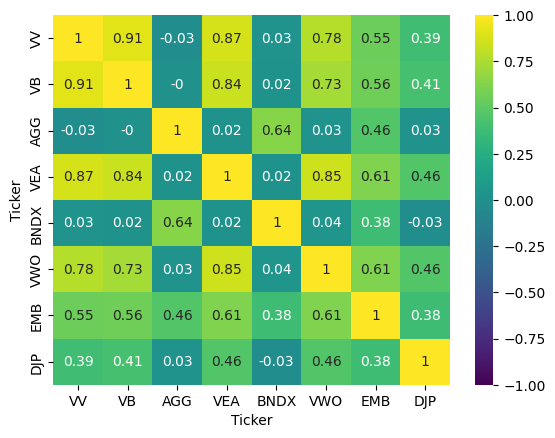

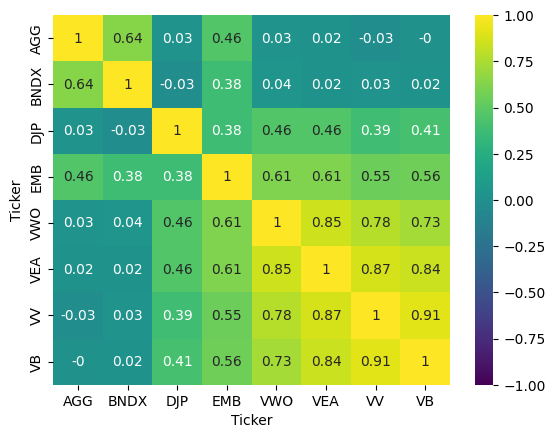

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
heatmap = sns.heatmap(np.round(corr, 2), vmin=-1, vmax=1, annot=True, cmap='viridis')
plt.show()

heatmap = sns.heatmap(np.round(corr.loc[ordering, ordering], 2), vmin=-1, vmax=1, annot=True, cmap='viridis')
plt.show()